# Diabetic Retinopathy Detection using ResNet with Attention Mechanism

This notebook implements a deep learning model for diabetic retinopathy detection using ResNet architecture with attention mechanism. The dataset contains 5 classes of diabetic retinopathy severity levels.

## Dataset Classes:
- **No_DR**: No diabetic retinopathy (1805 images)
- **Mild**: Mild diabetic retinopathy (370 images)
- **Moderate**: Moderate diabetic retinopathy (999 images)
- **Severe**: Severe diabetic retinopathy (193 images)
- **Proliferate_DR**: Proliferative diabetic retinopathy (295 images)


## 1. Import Required Libraries


In [ ]:
!pip3 install numpy

In [ ]:
!pip install --upgrade pip

zsh:1: command not found: pip


In [ ]:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn 

In [ ]:
!pip3 install scikit-learn

In [ ]:
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context  # temporary fix


In [ ]:
!pip3 install torch

In [ ]:
!pip3 install torchvision

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import torch.nn.functional as F

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


Using device: cpu


## 2. Dataset Configuration and Data Loading


In [ ]:
# Dataset configuration
DATA_DIR = '/Users/landaganesh/Documents/Projects /Miniproject/colored_images'
CLASSES = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.001

print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASSES}")


Number of classes: 5
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


In [ ]:
# Create dataset mapping
def create_dataset_mapping(data_dir, classes):
    """
    Create a mapping of image paths to their corresponding labels
    """
    data = []
    
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_file)
                    data.append({
                        'image_path': img_path,
                        'label': class_idx,
                        'class_name': class_name
                    })
    
    return pd.DataFrame(data)

# Create dataset
df = create_dataset_mapping(DATA_DIR, CLASSES)
print(f"Total images: {len(df)}")
print(f"\nClass distribution:")
print(df['class_name'].value_counts())

# Display sample data
print(f"\nSample data:")
print(df.head())


Total images: 3662

Class distribution:
class_name
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64

Sample data:
                                          image_path  label class_name
0  /Users/landaganesh/Documents/Projects /Minipro...      0      No_DR
1  /Users/landaganesh/Documents/Projects /Minipro...      0      No_DR
2  /Users/landaganesh/Documents/Projects /Minipro...      0      No_DR
3  /Users/landaganesh/Documents/Projects /Minipro...      0      No_DR
4  /Users/landaganesh/Documents/Projects /Minipro...      0      No_DR


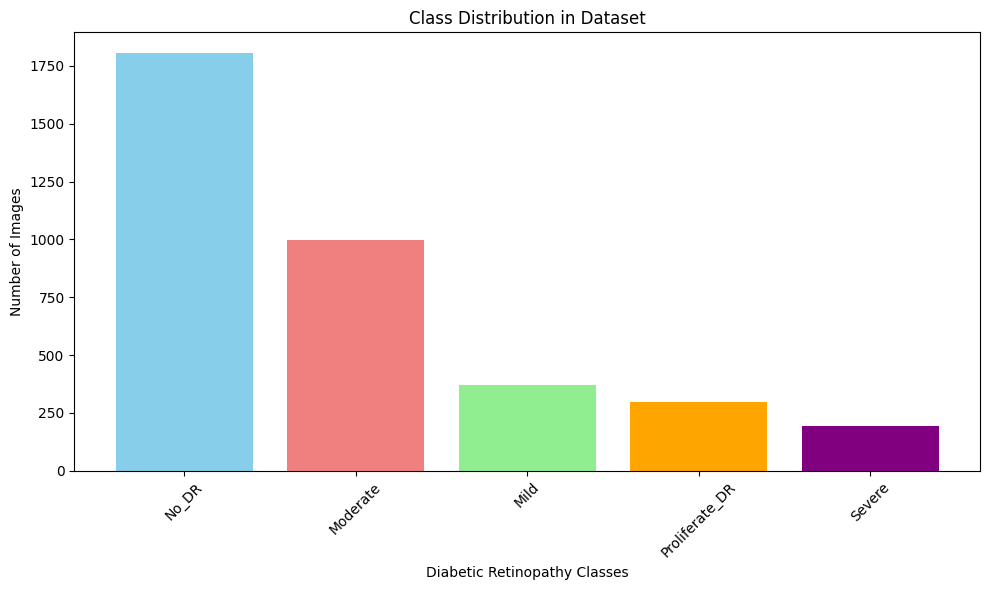


Class weights: [0.40576177 1.97945946 0.73313313 3.79481865 2.48271186]


In [ ]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
class_counts = df['class_name'].value_counts()
plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'purple'])
plt.title('Class Distribution in Dataset')
plt.xlabel('Diabetic Retinopathy Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate class weights for handling imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"\nClass weights: {class_weights}")


## 3. Custom Dataset Class and Data Preprocessing


In [ ]:
class DiabeticRetinopathyDataset(Dataset):
    """
    Custom dataset class for diabetic retinopathy images
    """
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if loading fails
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms defined successfully!")


Data transforms defined successfully!


## 4. Train-Validation Split


In [ ]:
# Split the dataset into train and validation sets
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create datasets
train_dataset = DiabeticRetinopathyDataset(train_df, transform=train_transform)
val_dataset = DiabeticRetinopathyDataset(val_df, transform=val_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32,
    shuffle=True,
    num_workers=0  # add this line or change it to 0 if it exists
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0  # add this line or change it to 0 if it exists
)


print(f"Data loaders created successfully!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Training samples: 2929
Validation samples: 733
Data loaders created successfully!
Training batches: 92
Validation batches: 23


## 5. Attention Mechanism Implementation


In [ ]:
class ChannelAttention(nn.Module):
    """
    Channel Attention Module
    """
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    """
    Spatial Attention Module
    """
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    """
    Convolutional Block Attention Module (CBAM)
    Combines Channel and Spatial Attention
    """
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def forward(self, x):
        # Apply channel attention
        x = x * self.channel_attention(x)
        # Apply spatial attention
        x = x * self.spatial_attention(x)
        return x

print("Attention mechanisms defined successfully!")


Attention mechanisms defined successfully!


## 6. ResNet with Attention Model


In [ ]:
import ssl, certifi

# Use certifi's CA bundle for verified contexts
ssl_context = ssl.create_default_context(cafile=certifi.where())
ssl._create_default_https_context = lambda *args, **kwargs: ssl_context


In [ ]:
import requests
import certifi

url = "https://download.pytorch.org"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'
}

response = requests.get(url, headers=headers, verify=certifi.where())

print("Status code:", response.status_code)


Status code: 403


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights

# Device setup for Apple Silicon MPS (Mac M1/M2)
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# Define CBAM module (Convolutional Block Attention Module)
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channels = channels

        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction_ratio, channels, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()

        # Spatial Attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        # Channel Attention
        b, c, h, w = x.size()
        avg_pool = self.avg_pool(x).view(b, c)
        max_pool = self.max_pool(x).view(b, c)

        avg_out = self.mlp(avg_pool)
        max_out = self.mlp(max_pool)

        channel_attn = self.sigmoid_channel(avg_out + max_out).view(b, c, 1, 1)
        x = x * channel_attn.expand_as(x)

        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attn = torch.cat([avg_out, max_out], dim=1)
        spatial_attn = self.sigmoid_spatial(self.conv_spatial(spatial_attn))
        x = x * spatial_attn.expand_as(x)

        return x

# Define the full model with ResNet50 backbone and CBAM attention
class ResNetWithAttention(nn.Module):
    def __init__(self, num_classes=5, pretrained=True):
        super(ResNetWithAttention, self).__init__()
        weights = ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        backbone = resnet50(weights=weights)

        # Use backbone layers explicitly
        self.conv1 = backbone.conv1
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool
        self.layer1 = backbone.layer1  # 256 channels
        self.layer2 = backbone.layer2  # 512 channels
        self.layer3 = backbone.layer3  # 1024 channels
        self.layer4 = backbone.layer4  # 2048 channels

        # CBAM attention modules with correct channel numbers
        self.attention1 = CBAM(256)    # layer1 output channels
        self.attention2 = CBAM(512)    # layer2 output channels
        self.attention3 = CBAM(1024)   # layer3 output channels
        self.attention4 = CBAM(2048)   # layer4 output channels

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.attention1(x)

        x = self.layer2(x)
        x = self.attention2(x)

        x = self.layer3(x)
        x = self.attention3(x)

        x = self.layer4(x)
        x = self.attention4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Example usage:
num_classes = 5
model = ResNetWithAttention(num_classes=num_classes, pretrained=True).to(device)

# Optimizer, Loss, Scheduler example
LEARNING_RATE = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("Model and training setup complete.")

# Dummy test input to check if model runs correctly on MPS
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(dummy_input)
print("Output shape:", output.shape)


Using device: mps
Model and training setup complete.
Output shape: torch.Size([1, 5])


## 7. Training Configuration


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5
)

print(f"Loss function: CrossEntropyLoss with class weights")
print(f"Optimizer: Adam with learning rate {LEARNING_RATE}")
print(f"Scheduler: ReduceLROnPlateau")
print(f"Training configuration completed!")


Loss function: CrossEntropyLoss with class weights
Optimizer: Adam with learning rate 0.0001
Scheduler: ReduceLROnPlateau
Training configuration completed!


## 8. Training and Validation Functions


In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_predictions, all_targets

print("Training and validation functions defined successfully!")


Training and validation functions defined successfully!


## 9. Training Loop


In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
best_model_state = None

device = torch.device("cpu")  # Force CPU usage
print(f"Using device: {device}")
model.to(device)  # Move model to CPU

print("Starting training...")
print(f"Training for {EPOCHS} epochs")
print("-" * 50)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_predictions, val_targets = validate_epoch(model, val_loader, criterion, device)
    
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"New best validation accuracy: {best_val_acc:.2f}%")
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    if epoch > 10 and val_acc < max(val_accuracies[-10:]) - 5:
        print("Early stopping triggered!")
        break

print("\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")


Using device: cpu
Starting training...
Training for 20 epochs
--------------------------------------------------

Epoch 1/20
------------------------------
Batch 0/92, Loss: 1.6054
Batch 50/92, Loss: 1.5997
New best validation accuracy: 52.93%
Train Loss: 1.5603, Train Acc: 51.49%
Val Loss: 1.5434, Val Acc: 52.93%
Current LR: 0.000100

Epoch 2/20
------------------------------
Batch 0/92, Loss: 1.4740


## 10. Load Best Model and Evaluate


In [ ]:
# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model loaded!")

# Final evaluation
print("\nFinal evaluation on validation set...")
val_loss, val_acc, val_predictions, val_targets = validate_epoch(model, val_loader, criterion, device)

print(f"Final Validation Accuracy: {val_acc:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(val_targets, val_predictions, target_names=CLASSES))


## 11. Visualization of Training Progress


In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## 12. Confusion Matrix


In [ ]:
# Confusion Matrix
cm = confusion_matrix(val_targets, val_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, class_name in enumerate(CLASSES):
    print(f"{class_name}: {class_accuracies[i]:.3f}")


## 13. Sample Predictions Visualization


In [ ]:
def visualize_predictions(model, val_loader, class_names, num_samples=8):
    """
    Visualize sample predictions
    """
    model.eval()
    
    # Get a batch of validation data
    data_iter = iter(val_loader)
    images, labels = next(data_iter)
    
    # Move to device
    images = images.to(device)
    labels = labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)
    
    # Move back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()
    
    # Create subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(images))):
        # Denormalize image for display
        img = images[i]
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)
        
        # Plot image
        axes[i].imshow(img)
        axes[i].set_title(f'True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}\nConf: {probabilities[i][predicted[i]]:.3f}')
        axes[i].axis('off')
        
        # Color code the title based on correctness
        if labels[i] == predicted[i]:
            axes[i].title.set_color('green')
        else:
            axes[i].title.set_color('red')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
print("Sample Predictions:")
visualize_predictions(model, val_loader, CLASSES, num_samples=8)


## 14. Save Model


In [ ]:
# Save the trained model
model_save_path = '/Users/landaganesh/Documents/Projects /Miniproject/diabetic_retinopathy_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': CLASSES,
    'num_classes': NUM_CLASSES,
    'img_size': IMG_SIZE,
    'best_val_acc': best_val_acc,
    'training_history': {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }
}, model_save_path)

print(f"Model saved to: {model_save_path}")
print(f"Model includes:")
print(f"- Model weights")
print(f"- Class names: {CLASSES}")
print(f"- Number of classes: {NUM_CLASSES}")
print(f"- Image size: {IMG_SIZE}")
print(f"- Best validation accuracy: {best_val_acc:.2f}%")


## 15. Model Summary and Performance Metrics


In [ ]:
# Print final summary
print("=" * 60)
print("DIABETIC RETINOPATHY DETECTION MODEL SUMMARY")
print("=" * 60)
print(f"Dataset: {len(df)} total images")
print(f"Classes: {CLASSES}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Model: ResNet50 with CBAM Attention")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs trained: {len(train_losses)}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Final validation accuracy: {val_acc:.2f}%")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("=" * 60)

# Print class-wise performance
print("\nCLASS-WISE PERFORMANCE:")
print("-" * 30)
for i, class_name in enumerate(CLASSES):
    print(f"{class_name}: {class_accuracies[i]:.3f} accuracy")

print("\nTraining completed successfully!")
print(f"Model saved to: {model_save_path}")
